In [33]:
# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
import os
import textstat
import numpy as np
import gc
from sklearn.decomposition import LatentDirichletAllocation

# Colour scheme
legal_ease_palette = ['#2d6aa2', '#ffde59'] # Same as AT2 poster plots

# Set global theme for all plots
sns.set_theme(style="whitegrid")
sns.set_palette(legal_ease_palette)

In [2]:
# Load Parquet file
file_path = 'nsw_corpus_final.parquet'

print(f"Loading final NSW corpus from: {file_path}")

if not os.path.exists(file_path):
    print(f"ERROR: File not found at '{file_path}'")
else:
    # Load Parquet df
    df_nsw = pd.read_parquet(file_path)
    print("NSW dataset loaded successfully")

    # Validation
    df_nsw.info(memory_usage='deep')

    print("\nFirst 5 rows")
    print(df_nsw.head())

Loading final NSW corpus from: nsw_corpus_final.parquet
NSW dataset loaded successfully
<class 'pandas.core.frame.DataFrame'>
Index: 119587 entries, 12 to 232559
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   version_id    119587 non-null  object        
 1   type          119587 non-null  object        
 2   jurisdiction  119587 non-null  object        
 3   source        119587 non-null  object        
 4   mime          119587 non-null  object        
 5   date          118942 non-null  datetime64[ns]
 6   citation      119587 non-null  object        
 7   url           119587 non-null  object        
 8   when_scraped  119587 non-null  object        
 9   text          119587 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 8.4 GB

First 5 rows
                                 version_id                 type  \
12  nsw_legislation:2009-07-06/act-1968-059  primary_

In [3]:
# Duplicates double check just in case
num_duplicates_id = df_nsw.duplicated(subset=['version_id']).sum()
num_duplicates_text = df_nsw.duplicated(subset=['text']).sum()

print(f"Number of duplicate documents based on 'version_id': {num_duplicates_id}")
print(f"Number of duplicate documents based on 'text': {num_duplicates_text}")
if num_duplicates_id == 0 and num_duplicates_text == 0:
    print("No duplicates found")
else:
    print("Duplicates found. Deal with these before proceeding")

Number of duplicate documents based on 'version_id': 0
Number of duplicate documents based on 'text': 0
No duplicates found


type
decision                 117371
primary_legislation        1418
secondary_legislation       798
Name: count, dtype: int64


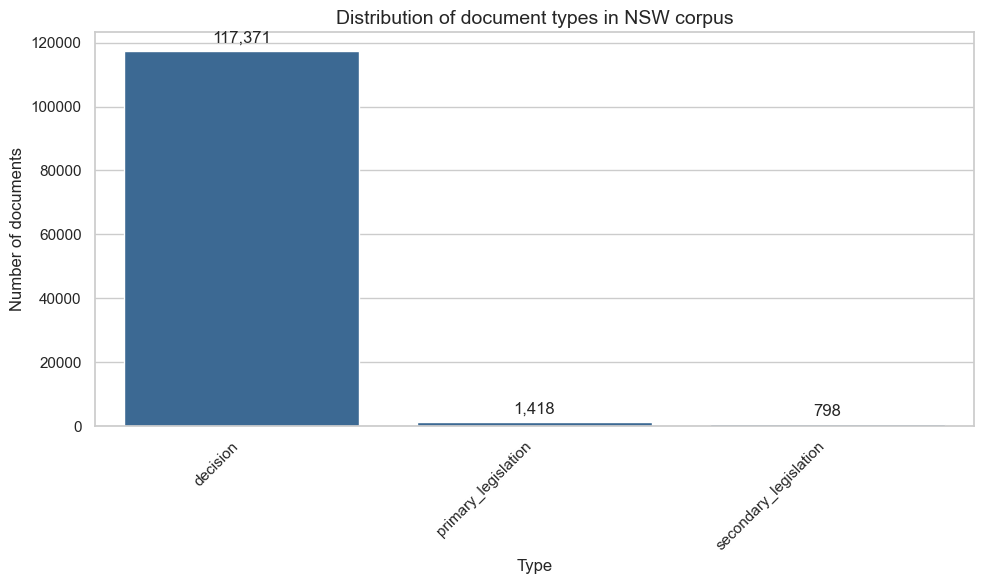

In [5]:
# Plot NSW document type distribution
type_counts = df_nsw['type'].value_counts()
print(type_counts)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=type_counts.index, y=type_counts.values, legend=False)
plt.title('Distribution of document types in NSW corpus', fontsize=14)
plt.ylabel('Number of documents')
plt.xlabel('Type')
plt.xticks(rotation=45, ha='right')

# Labels
for p in ax.patches:
    label = f'{int(p.get_height()):,}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

source
nsw_caselaw        117371
nsw_legislation      2216
Name: count, dtype: int64


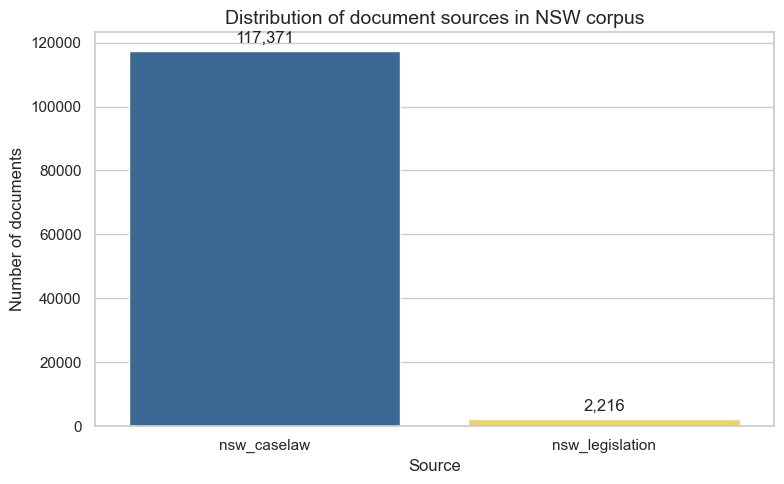

In [6]:
# Plot NSW document source distribution
source_counts = df_nsw['source'].value_counts()
print(source_counts)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=source_counts.index, y=source_counts.values, hue=source_counts.index, legend=False)
plt.title('Distribution of document sources in NSW corpus', fontsize=14)
plt.ylabel('Number of documents')
plt.xlabel('Source')

# Labels
for p in ax.patches:
    label = f'{int(p.get_height()):,}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

In [7]:
# Document length analysis
print("\nCalculating word counts for all documents (this will take an age)")
if 'word_count' not in df_nsw.columns:
    df_nsw['word_count'] = df_nsw['text'].str.split().str.len()

print(df_nsw['word_count'].describe())


Calculating word counts for all documents (this will take an age)
count    119587.000000
mean       6703.296805
std        8696.778770
min          48.000000
25%        2230.000000
50%        4316.000000
75%        8061.000000
max      414869.000000
Name: word_count, dtype: float64


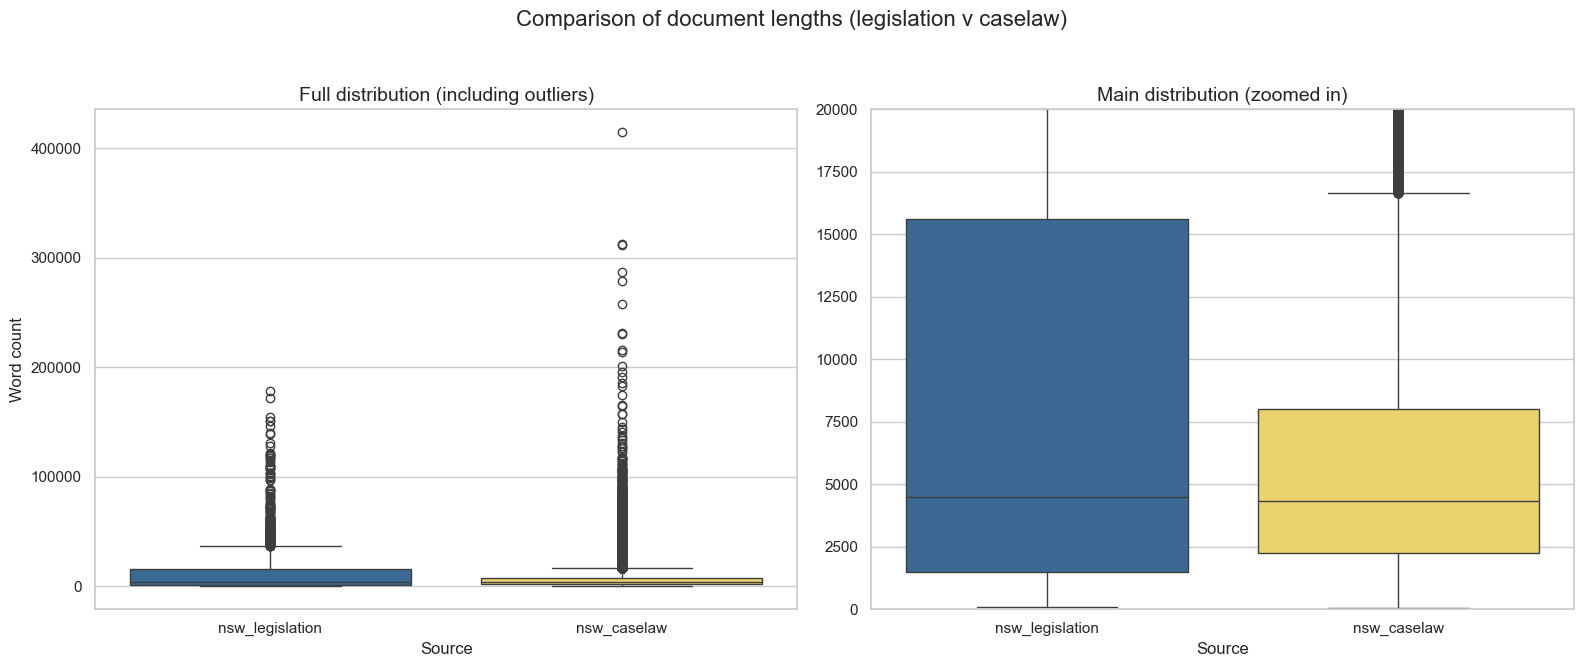

In [8]:
# Box plots of document lengths by source
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)
fig.suptitle('Comparison of document lengths (legislation v caselaw)', fontsize=16)

# Full distribution
sns.boxplot(ax=axes[0], x='source', y='word_count', data=df_nsw, hue='source', legend=False)
axes[0].set_title('Full distribution (including outliers)', fontsize=14)
axes[0].set_xlabel('Source', fontsize=12)
axes[0].set_ylabel('Word count', fontsize=12)

# Main distribution
sns.boxplot(ax=axes[1], x='source', y='word_count', data=df_nsw, hue='source', legend=False)
axes[1].set_title('Main distribution (zoomed in)', fontsize=14)
axes[1].set_xlabel('Source', fontsize=12)
axes[1].set_ylabel('')
axes[1].set_ylim(0, 20000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
# First-round legal jargon check using only English stopwords on df_nsw
stop_words_list = stopwords.words('english')

# Unigram frequency analysis
unigram_vectoriser_round1 = CountVectorizer(stop_words=stop_words_list, max_features=25)
unigram_counts_round1 = unigram_vectoriser_round1.fit_transform(df_nsw['text'])
unigram_freq_round1 = pd.Series(
    unigram_counts_round1.toarray().sum(axis=0),
    index=unigram_vectoriser_round1.get_feature_names_out()
).sort_values(ascending=False)

print(unigram_freq_round1)

mr             4110276
court          2537077
evidence       2413606
act            2364189
would          2163692
may            1803468
made           1789704
plaintiff      1634746
applicant      1576089
order          1401405
defendant      1337515
decision       1303451
said           1285918
time           1281018
application    1223789
case           1219017
proceedings    1202600
appeal         1188711
also           1150394
whether        1086360
person         1083964
respondent     1029321
costs          1020083
one            1000553
tribunal        979362
dtype: int64


In [10]:
# Create df for NSW legislation only
df_legislation = df_nsw[df_nsw['source'] == 'nsw_legislation'].copy()

# Create df for NSW caselaw only
df_caselaw = df_nsw[df_nsw['source'] == 'nsw_caselaw'].copy()

print(f"NSW legislation dataframe (df_legislation) shape: {df_legislation.shape}")
print(f"NSW Caselaw dataframe (df_caselaw) shape: {df_caselaw.shape}\n")

print(df_legislation.head(3))
print(df_caselaw.head(3))

NSW legislation dataframe (df_legislation) shape: (2216, 11)
NSW Caselaw dataframe (df_caselaw) shape: (117371, 11)

                                 version_id                 type  \
12  nsw_legislation:2009-07-06/act-1968-059  primary_legislation   
15  nsw_legislation:2021-07-01/act-2011-035  primary_legislation   
36  nsw_legislation:2017-06-08/act-1967-095  primary_legislation   

       jurisdiction           source       mime       date  \
12  new_south_wales  nsw_legislation  text/html 2009-07-06   
15  new_south_wales  nsw_legislation  text/html 2021-07-01   
36  new_south_wales  nsw_legislation  text/html 2017-06-08   

                                             citation  \
12  Broken Hill to South Australian Border Railway...   
15              Government Advertising Act 2011 (NSW)   
36     Technical Education Trust Funds Act 1967 (NSW)   

                                                  url  \
12  https://legislation.nsw.gov.au/view/whole/html...   
15  https://legisl

In [11]:
# Save subsets in JSONL and Parquet formats
output_dir = 'nsw_subsets'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

# Paths
leg_parquet_path = os.path.join(output_dir, 'nsw_legislation.parquet')
leg_jsonl_path = os.path.join(output_dir, 'nsw_legislation.jsonl')
case_parquet_path = os.path.join(output_dir, 'nsw_caselaw.parquet')
case_jsonl_path = os.path.join(output_dir, 'nsw_caselaw.jsonl')

# Save NSW legislation in Parquet format
df_legislation.to_parquet(leg_parquet_path)
print(f"Saved legislation data to {leg_parquet_path}")
# # Save NSW legislation in JSONL format
df_legislation.to_json(leg_jsonl_path, orient='records', lines=True)
print(f"Saved legislation data to {leg_jsonl_path}")

# Save NSW caselaw in Parquet format
df_caselaw.to_parquet(case_parquet_path)
print(f"Saved caselaw data to {case_parquet_path}")
# Save NSW caselaw in JSONL format
df_caselaw.to_json(case_jsonl_path, orient='records', lines=True)
print(f"Saved caselaw data to {case_jsonl_path}")

Saved legislation data to nsw_subsets\nsw_legislation.parquet
Saved legislation data to nsw_subsets\nsw_legislation.jsonl
Saved caselaw data to nsw_subsets\nsw_caselaw.parquet
Saved caselaw data to nsw_subsets\nsw_caselaw.jsonl


In [12]:
# Memory cleanse of redundant dataframes
del df_caselaw
del df_nsw

gc.collect()

print("Memory cleaned: df_caselaw and df_nsw culled, you're welcome")

Memory cleaned: df_caselaw and df_nsw culled, you're welcome


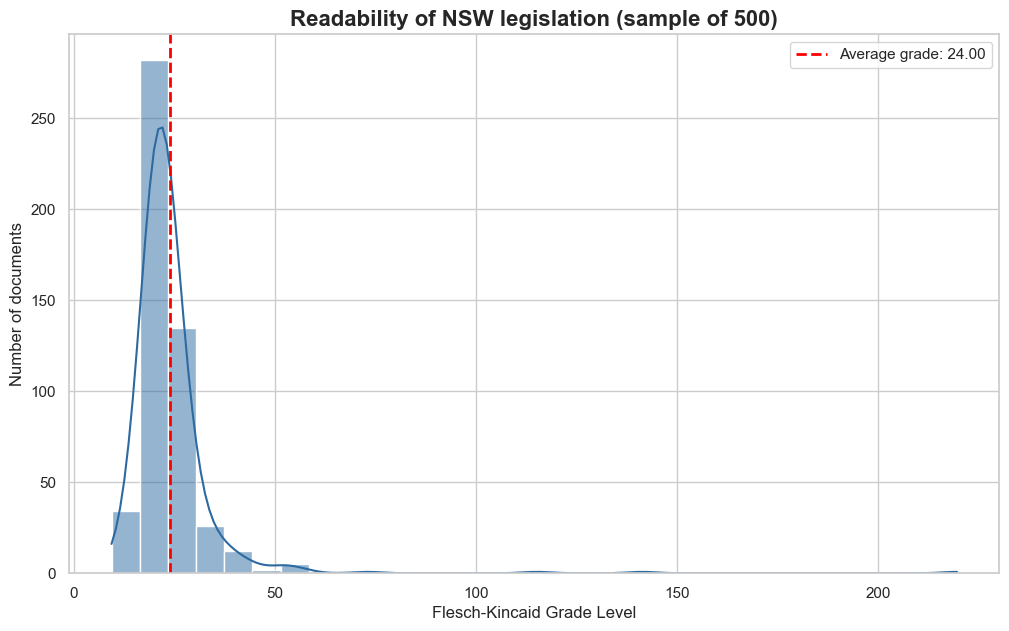

count    500.000000
mean      23.999485
std       12.900378
min        9.347205
25%       19.679803
50%       21.847016
75%       25.013950
max      219.648012
Name: readability_grade, dtype: float64


In [14]:
# Readability baseline for sample of NSW legislation
SAMPLE_SIZE = 500
df_leg_sample = df_legislation.sample(n=SAMPLE_SIZE, random_state=42)

# Calculate Flesch-Kincaid Grade Level for each sample document
df_leg_sample['readability_grade'] = df_leg_sample['text'].apply(textstat.flesch_kincaid_grade)

# Plot readability distribution
plt.figure(figsize=(12, 7))
sns.histplot(df_leg_sample['readability_grade'], bins=30, kde=True, color='#2d6aa2')
plt.title(f'Readability of NSW legislation (sample of {SAMPLE_SIZE})', fontsize=16, weight='bold')
plt.xlabel('Flesch-Kincaid Grade Level', fontsize=12)
plt.ylabel('Number of documents', fontsize=12)
plt.axvline(df_leg_sample['readability_grade'].mean(), color='red', linestyle='--', linewidth=2, label=f"Average grade: {df_leg_sample['readability_grade'].mean():.2f}")
plt.legend()
plt.show()

# Summary statistics
print(df_leg_sample['readability_grade'].describe())

In [31]:
# First-round legal jargon check using only English stopwords on df_legislation
stop_words_list = stopwords.words('english')

# Unigram frequency analysis
unigram_vectoriser_round1 = CountVectorizer(stop_words=stop_words_list, max_features=25)
unigram_counts_round1 = unigram_vectoriser_round1.fit_transform(df_legislation['text'])
unigram_freq_round1 = pd.Series(
    unigram_counts_round1.toarray().sum(axis=0),
    index=unigram_vectoriser_round1.get_feature_names_out()
).sort_values(ascending=False)

print(unigram_freq_round1)

act            208706
person         147579
section        135872
land           135356
may            132682
development    122364
part           100607
water           93071
means           91970
must            88208
local           66416
lot             63649
clause          63597
building        61074
authority       58309
consent         55482
made            54550
purposes        53789
area            53381
within          52859
dp              51877
shall           51849
plan            51602
public          48170
order           47759
dtype: int64


In [37]:
# Identify themes in NSW legislation jargon
unigram_vectoriser_leg = CountVectorizer(stop_words=stopwords.words('english'), max_features=1000, min_df=20)
doc_term_matrix = unigram_vectoriser_leg.fit_transform(df_legislation['text'])

# Run LDA model
N_TOPICS = 7
lda_model = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42)
lda_model.fit(doc_term_matrix)

feature_names = unigram_vectoriser_leg.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    print()

Topic 1
shall said company act may time one upon lands south

Topic 2
development land lot local building means dp consent zone area

Topic 3
must person penalty licence section vehicle may act authority units

Topic 4
water access plan source river licence supply work sources groundwater

Topic 5
person act section may part order made court must application

Topic 6
act land minister part state council section trust area public

Topic 7
mfg class employer employers engaged services rate included includes insurance



In [ ]:
# Second-round NSW legislation unigram check using custom stopwords
custom_legislation_stopwords = [
    # Structural legislative terms
    'act', 'section', 'part', 'clause', 'authority', 'order', 'schedule', 'regulation', 'plan',

    # Generic fluff
    'may', 'made', 'means', 'must', 'person', 'purposes', 'shall', 'within', 'public', 'said',

    # Topical noise
    'land', 'development', 'water', 'building', 'local', 'area', 'consent', 'work', 'access',

    # Other noise
    'dp', 'lot', 'nsw', 'including', 'state', 'note', 'use', 'used', 'time', 'whether',
    'applies', 'respect', 'minister'
]

stop_words_list_round2 = stopwords.words('english')
stop_words_list_round2.extend(custom_legislation_stopwords)

# Unigram frequency analysis
unigram_vectoriser_round2 = CountVectorizer(stop_words=stop_words_list_round2, max_features=25)
unigram_counts_round2 = unigram_vectoriser_round2.fit_transform(df_legislation['text'])
unigram_freq_round2 = pd.Series(
    unigram_counts_round2.toarray().sum(axis=0),
    index=unigram_vectoriser_round2.get_feature_names_out()
).sort_values(ascending=False)

print(unigram_freq_round2)

application      46154
following        46019
premises         44969
zone             42276
notice           41538
place            39414
court            38531
road             38415
specified        38250
facilities       37693
licence          37616
services         36856
relation         36827
environmental    36138
service          35889
division         35701
penalty          35384
management       35358
information      34039
period           33664
purpose          33363
council          33063
street           32769
subsection       31860
offence          31374
dtype: int64


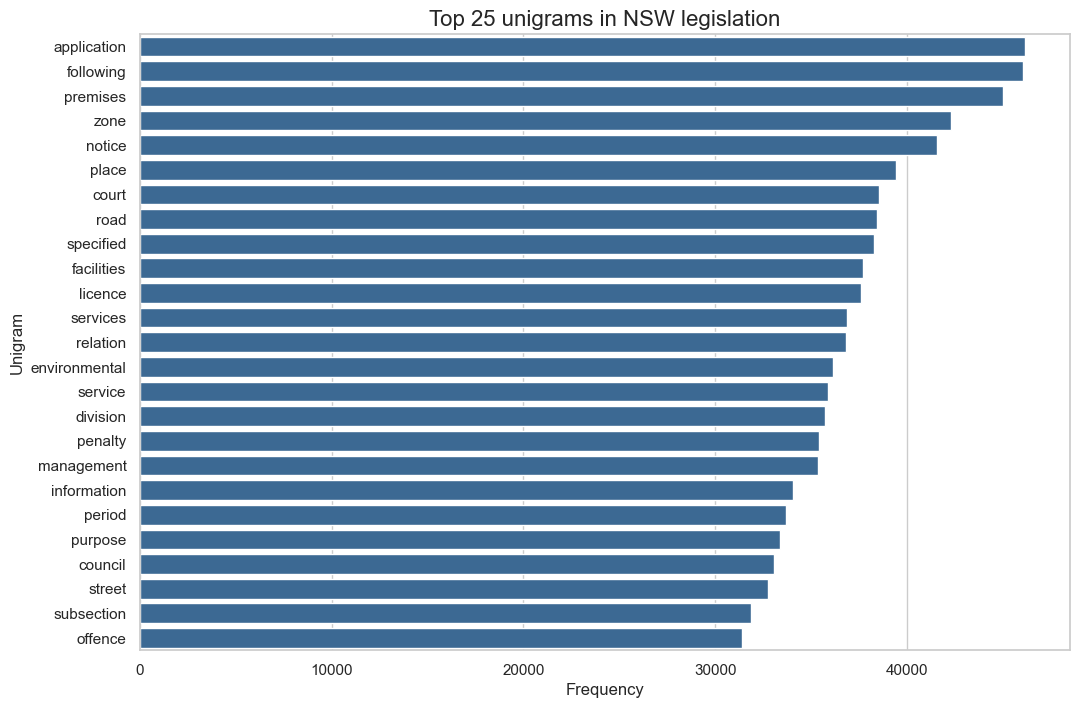

In [29]:
# Visualise top NSW legislation unigrams
plt.figure(figsize=(12, 8))
sns.barplot(x=unigram_freq_round2.values, y=unigram_freq_round2.index)
plt.title('Top 25 unigrams in NSW legislation', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Unigram', fontsize=12)
plt.show()

In [30]:
# Bigram frequency analysis
bigram_vectoriser = CountVectorizer(stop_words=stop_words_list_round2, ngram_range=(2, 2), max_features=25, min_df=10)
bigram_counts = bigram_vectoriser.fit_transform(df_legislation['text'])
bigram_freq = pd.Series(
    bigram_counts.toarray().sum(axis=0),
    index=bigram_vectoriser.get_feature_names_out()
).sort_values(ascending=False)

print(bigram_freq)

see definition            16917
definition term           16775
term dictionary           16750
new south                 15298
south wales               15223
penalty units             14049
environmental planning    12784
maximum penalty           11589
included class             7105
prescribed regulations     6581
co operative               6417
based aquaculture          6363
authorised officer         6195
motor vehicle              6097
employers engaged          5977
includes employers         5778
heritage significance      5695
planning policy            5624
dwelling house             5602
heritage conservation      5482
food drink                 5434
heritage item              5381
primary activities         5340
class includes             5310
supreme court              5028
dtype: int64


In [20]:
# Legislative interconnectivity feasibility check for knowledge graph
act_pattern = r'\b\w[\w\s]+Act\s+\d{4}\b' # Regex pattern to match "Some Act 1900"

# Check on legislation dataframe
docs_with_links = df_legislation['text'].str.contains(act_pattern, regex=True, case=False)
num_docs_with_links = docs_with_links.sum()
total_docs = len(df_legislation)
percentage_with_links = (num_docs_with_links / total_docs) * 100

print(f"Legislative documents containing a reference to another Act: {num_docs_with_links:,}")
print(f"Percentage of legislation corpus with potential graph connections: {percentage_with_links:.2f}%")

Legislative documents containing a reference to another Act: 1,668
Percentage of legislation corpus with potential graph connections: 75.27%


In [22]:
# NER feasibility check: penalty clauses
penalty_pattern = r'penalty units'
docs_with_penalties = df_legislation['text'].str.contains(penalty_pattern, regex=True, case=False)
num_docs_with_penalties = docs_with_penalties.sum()
total_docs = len(df_legislation) 
percentage_with_penalties = (num_docs_with_penalties / total_docs) * 100

print(f"Documents containing the phrase 'penalty units': {num_docs_with_penalties:,}")
print(f"Percentage of corpus mentioning penalty units: {percentage_with_penalties:.2f}%")

Documents containing the phrase 'penalty units': 565
Percentage of corpus mentioning penalty units: 25.50%
